# 自动驾驶之车辆探测

感谢大家来我的网站学习https://www.captainbed.net

本次实战编程我将带领大家实现自动驾驶中的车辆探测功能。使用的探测法是YOLO探测法。当然，要训练好一个优秀的YOLO模型是需要很多数据和计算力的，所以，本次编程中我们使用了开源的已经训练好了的YOLO模型。YOLO模型给出结果后，还需要进行剔除小概率边框和非最大值抑制，这些部分由我们自己实现。

In [1]:
import numpy as np
import tensorflow as tf
# 需要安装pip install opencv-python==4.5.3.56
import cv2
from IPython.display import Image, display
from tensorflow.keras.models import load_model
from yolo_utils import read_classes, read_anchors, yolo_head, preprocess_image, generate_colors, draw_outputs


%matplotlib inline

## 1 - 如何制作数据集

如果你要制造一台自动驾驶汽车，那么你必须要先实现车辆探测系统，这样才能避免与其它车辆相撞。

为了采集数据，你可以在汽车的上面安装一个照相机，然后开着车到马路上溜达溜达，照相机会每几秒拍一个照片。其实百度地图里面的全景模式也是通过这种方式采集的相片。可能有些同学在马路上还遇到过百度采集车，就是一辆小车上面喷着百度的图标，上面还有很多摄像头，在马路上慢慢地行驶着。

<center>
<video width="400" height="200" src="nb_images/road_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>


采集到相片后，就需要给这些相片打上标签。如下图所示。

<img src="nb_images/box_label.png" style="width:500px;height:250;">
<caption><center> <u> **图 1** </u>: 给图片打标签<br> </center></caption>

图中的p<sub>c</sub>表示有物体的概率,1就表示100%有物体，0表示绝对没有物体。c表示物体的种类，是行人还是汽车...其实有两种表示方法，假如你要识别80种物体，那么一种方法是用1到80的整数来表示不同的种类，上图中c=3就表示是汽车；另一种方法是用一个有80个元素的向量的表示，也就是说每个元素代表一个种类，如果值是1就表示肯定是这个种类，如果是0就表示绝对不可能是这个种类，在前面的文章中我们主要使用的是这种方法。而在本次实战编程中，我们会两种方法都用，具体取决于在某个步骤时用哪个方法比较方便。

## 2 - YOLO探测法

YOLO ("you only look once")是一个非常流行的算法，因为它不仅精准度高，而且由于计算量较小还可以被用于实时探测。

### 2.1 - YOLO模型细节

本次编程我们使用的是github上一个已经训练好了的YOLO模型:  (我们这次用的是yolov3)
- 这个模型的输入维度是(m, 416, 416, 3)。m是图片的个数，416是图片像素值。 
- 它会输出识别出来的物体类别以及它的边框坐标. 每个边框都对应着6个元素 $(p_c, b_x, b_y, b_h, b_w, c)$。当然，如果c是用一个包含80个元素的向量来表示的话，那么每个边框就对应着85个元素。
- yolov3使用了3种不同规格的格子，分别把图片分成了13，26，52个格子。所以yolov3会输出3组结果。当然，格子越多就意味着格子越小，那么就能检测出更小的物体。之前yolov2只把图片分成了一种规格的格子，导致经常检测不出小的物体，所以yolov3增加了两个规格的格子来支持小物体。另外，yolov3为每个格子安排了3种anchor boxes。所以yolov3最终会输出3组以下维度的结果：（m,13,13,3,85)，（m,26,26,3,85)，(m,52,52,3,85)

假设下图中的各种框框是识别出来的物体。可以看出，有不少框框是重叠的。所以我们会先去掉哪些概率小的边框，然后再使用非最大值抑制算法来去掉哪些重叠的边框。

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u> **图 6** </u><br> </center></caption>

### 2.2 - 过滤掉概率小的边框

In [2]:
# 过滤掉那些概率低的边框
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """
    box_confidence -- 装载着每个边框的pc
    boxes -- 装载着每个边框的坐标
    box_class_probs -- 装载着每个边框的80个种类的概率
    threshold -- 阈值，概率低于这个值的边框会被过滤掉
    
    返回值:
    scores -- 装载保留下的那些边框的概率
    boxes -- 装载保留下的那些边框的坐标
    classes -- 装载保留下的那些边框的种类的索引
    
    """
    
    # 将pc和c相乘，得到具体某个种类是否存在的概率
    box_scores = box_confidence * box_class_probs
    
    
    box_classes = tf.argmax(box_scores, axis=-1) # 获取概率最大的那个种类的索引
    box_class_scores = tf.reduce_max(box_scores, axis=-1) # 获取概率最大的那个种类的概率值

    
    # 创建一个过滤器。当某个种类的概率值大于等于阈值threshold时，
    # 对应于这个种类的filtering_mask中的位置就是true，否则就是false。
    # 所以filtering_mask就是[False, True, 。。。, False, True]这种形式。
    filtering_mask = tf.greater_equal(box_class_scores, threshold)

    
    # 用上面的过滤器来过滤掉那些概率小的边框。
    # 过滤完成后，scores和boxes，classes里面就只装载了概率大的边框的概率值和坐标以及种类索引了。
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [3]:

box_confidence = tf.random.normal([13, 13, 3, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([13, 13, 3, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([13, 13, 3, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
print("scores[2] = ",scores[2])
print("boxes[2] = " , boxes[2])
print("classes[2] = " , classes[2])
print("scores.shape = " , scores.shape)
print("boxes.shape = " , boxes.shape)
print("classes.shape = " , classes.shape)

scores[2] =  tf.Tensor(12.552861, shape=(), dtype=float32)
boxes[2] =  tf.Tensor([ 3.8289614   0.14167517 -0.03989506 -3.3593693 ], shape=(4,), dtype=float32)
classes[2] =  tf.Tensor(46, shape=(), dtype=int64)
scores.shape =  (500,)
boxes.shape =  (500, 4)
classes.shape =  (500,)


### 2.3 - 非最大值抑制 Non-max suppression ###

上面我们使用阈值过滤掉了一些小概率的边框，但是依然有很多重叠的边框。这一步我们将使用非最大值抑制 Non-max suppression(NMS)技术来过滤掉那些重叠的边框。

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> **图 7** </u>: 左图中3个边框预测的其实都是同一辆车，通过NMS后，去掉重叠的边框，只保留概率值最大的那个，得到右图 <br> </center></caption>


NMS的主要步骤如下
1. 找到概率值最高的一个边框
2. 找到与这个边框高度重叠的其它边框，也就是交并比很高的其它边框，然后过滤掉它们。当然，交并比到底多高才过滤掉呢？为此我们会给定一个阈值`iou_threshold`.
3. 重复进行上面两步

In [4]:
# 用非最大值抑制技术过滤掉重叠的边框

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 20, iou_threshold = 0.5):
    """
    参数:
    scores -- 前面yolo_filter_boxes函数保留下的那些边框的概率值
    boxes -- 前面yolo_filter_boxes函数保留下的那些边框的坐标
    classes -- 前面yolo_filter_boxes函数保留下的那些边框的种类的索引
    max_boxes -- 最多想要保留多少个边框
    iou_threshold -- 交并比，这是一个阈值，也就是说交并比大于这个阈值的边框才会被进行非最大值抑制处理
    
    Returns:
    scores -- NMS保留下的那些边框的概率值
    boxes -- NMS保留下的那些边框的坐标
    classes -- NMS保留下的那些边框的种类的索引
    """
    
    # tensorflow为我们提供了一个NMS函数，我们直接调用就可以了tf.image.non_max_suppression()。
    # 这个函数会返回NMS后保留下来的边框的索引
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold=iou_threshold)

    # 通过上面的索引来分别获取被保留的边框的相关概率值，坐标以及种类的索引
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [5]:
scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
print("scores[2] = ", scores[2])
print("boxes[2] = " , boxes[2])
print("classes[2] = " , classes[2])
print("scores.shape = ", scores.shape)
print("boxes.shape = ", boxes.shape)
print("classes.shape = " , classes.shape)

scores[2] =  tf.Tensor(8.208248, shape=(), dtype=float32)
boxes[2] =  tf.Tensor([ 5.8494906  -0.32543743  0.8039762  -3.6349177 ], shape=(4,), dtype=float32)
classes[2] =  tf.Tensor(-5.3616023, shape=(), dtype=float32)
scores.shape =  (20,)
boxes.shape =  (20, 4)
classes.shape =  (20,)


### 2.4 最终的过滤函数

In [6]:
# 这个函数里面整合了前面我们实现的两个过滤函数。将YOLO模型的输出结果输入到这个函数后，这个函数会将多余边框过滤掉

def yolo_eval(outputs, max_boxes=20, score_threshold=.5, iou_threshold=.5):
    """
    参数:
    yolo_outputs -- YOLO模型的输出结果
    max_boxes -- 你希望最多识别出多少个边框
    score_threshold -- 概率值阈值
    iou_threshold -- 交并比阈值
    
    Returns:
    scores -- 最终保留下的那些边框的概率值
    boxes -- 最终保留下的那些边框的坐标
    classes -- 最终保留下的那些边框的种类的索引
    """
    #建立3个空list
    s, b, c = [], [], []
    
    # 我们后面我们调用的Yolov3使用了3个规格的网格（13*13，26*26，52*52）进行预测。所以有3组output。
    for output in outputs:
        
        ### 将YOLO输出结果分成3份，分别表示概率值，坐标，种类索引
        box_confidence, boxes,  box_class_probs = output

        # 使用我们前面实现的yolo_filter_boxes函数过滤掉概率值低于阈值的边框
        scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, 
                                                   threshold = score_threshold)
        
        s.append(scores)
        b.append(boxes)
        c.append(classes)
    
    #将3组output的结果整合到一起
    scores = tf.concat(s, axis=0)
    boxes = tf.concat(b, axis=0)
    classes = tf.concat(c, axis=0)
    

    # 使用我们前面实现的yolo_non_max_suppression过滤掉重叠的边框
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, 
                                                      iou_threshold = iou_threshold)
      
    return scores, boxes, classes

In [7]:
yolo_output = (tf.random.normal([13, 13, 3, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([13, 13, 3, 4], mean=1, stddev=4, seed = 1),
                tf.random.normal([13, 13, 3, 80], mean=1, stddev=4, seed = 1))
yolo_output1 = (tf.random.normal([26, 26, 3, 1], mean=1, stddev=4, seed = 2),
                tf.random.normal([26, 26, 3, 4], mean=1, stddev=4, seed = 2),
                tf.random.normal([26, 26, 3, 80], mean=1, stddev=4, seed = 2))
yolo_output2 = (tf.random.normal([52, 52, 3, 1], mean=1, stddev=4, seed = 3),
                tf.random.normal([52, 52, 3, 4], mean=1, stddev=4, seed = 3),
                tf.random.normal([52, 52, 3, 80], mean=1, stddev=4, seed = 3))
yolo_outputs = (yolo_output, yolo_output1, yolo_output2)
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = ", scores[2])
print("boxes[2] = " , boxes[2])
print("classes[2] = ", classes[2])
print("scores.shape = ", scores.shape)
print("boxes.shape = ", boxes.shape)
print("classes.shape = " , classes.shape)

scores[2] =  tf.Tensor(183.36862, shape=(), dtype=float32)
boxes[2] =  tf.Tensor([-0.9321569  1.2601769 -0.5666194 -1.3579395], shape=(4,), dtype=float32)
classes[2] =  tf.Tensor(23, shape=(), dtype=int64)
scores.shape =  (20,)
boxes.shape =  (20, 4)
classes.shape =  (20,)


## 3 - 使用YOLO模型进行车辆探测

下面我们将结合github上训练好的YOLO模型以及我们自己实现的过滤函数来进行车辆探测！

### 3.1 - 定义种类以及anchor box和像素

我们已经将种类和anchor box的信息保存在了"coco_classes.txt" 和 "yolo_anchors.txt"文件中了。所以从它们里面读取出来就可以了。

In [8]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt") 

### 3.2 - 加载已经训练好了的YOLO模型

如何执行这句时出现错误提示，那么你就要重新生成与自己开发环境匹配的yolo_model.h5。

步骤如下：

1，在jupyter notebook中打开yolov3-tf2文件夹下面的model by myself-Copy1.ipynb

2，运行model by myself-Copy1.ipynb

3，将生成的yolo_model.h5复制到model_data文件夹中

In [9]:
yolo_model = load_model("model_data/yolo_model.h5")

In [10]:
yolo_model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       [(None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, 13, 13, 512)  11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, 26, 26, 256)  2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

### 3.3 -探测图片

读取图片数据，并输入到yolo_model中，得到探测结果

In [11]:
img_raw, img = preprocess_image("test.jpg", model_image_size = (416, 416))
yolo_outputs = yolo_model(img)

### 3.4 - 将YOLO模型的输出结果转换成我们需要的格式

In [12]:
outputs = yolo_head(yolo_outputs, anchors, len(class_names))

### 3.5 - 过滤边框

`yolo_model`输出的`yolo_outputs`里面包含了它探测到的所有的边框。下面我们将使用我们自己实现的过滤函数yolo_eval来过滤掉多余的边框。

In [13]:
out_scores, out_boxes, out_classes = yolo_eval(outputs)

### 3.6 - 将检测到的boxes在图片中显示出来

In [14]:
def img_show(image_file, out_scores, out_boxes, out_classes, class_names):
    img_raw = tf.image.decode_image(open('./images/'+image_file, 'rb').read(), channels=3)
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    colors = generate_colors(class_names)
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    img = draw_outputs(img, out_scores, out_boxes, out_classes, colors, class_names)
    display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
    file_name = [x for x in image_file.split('.')]
    cv2.imwrite('./out/'+file_name[0]+'_out.'+file_name[1], img)
    return img

Found 12 boxes for test.jpg
car 1.00 (353, 295) (755, 645)
car 1.00 (761, 286) (923, 404)
car 1.00 (944, 322) (1288, 701)
car 0.99 (925, 294) (1054, 379)
car 0.99 (142, 304) (330, 449)
car 0.91 (709, 281) (778, 347)
car 0.88 (309, 303) (366, 355)
car 0.80 (385, 291) (437, 325)
car 0.75 (673, 279) (720, 321)
traffic light 0.70 (680, 194) (690, 210)
car 0.68 (965, 272) (1025, 290)
truck 0.60 (579, 247) (644, 298)


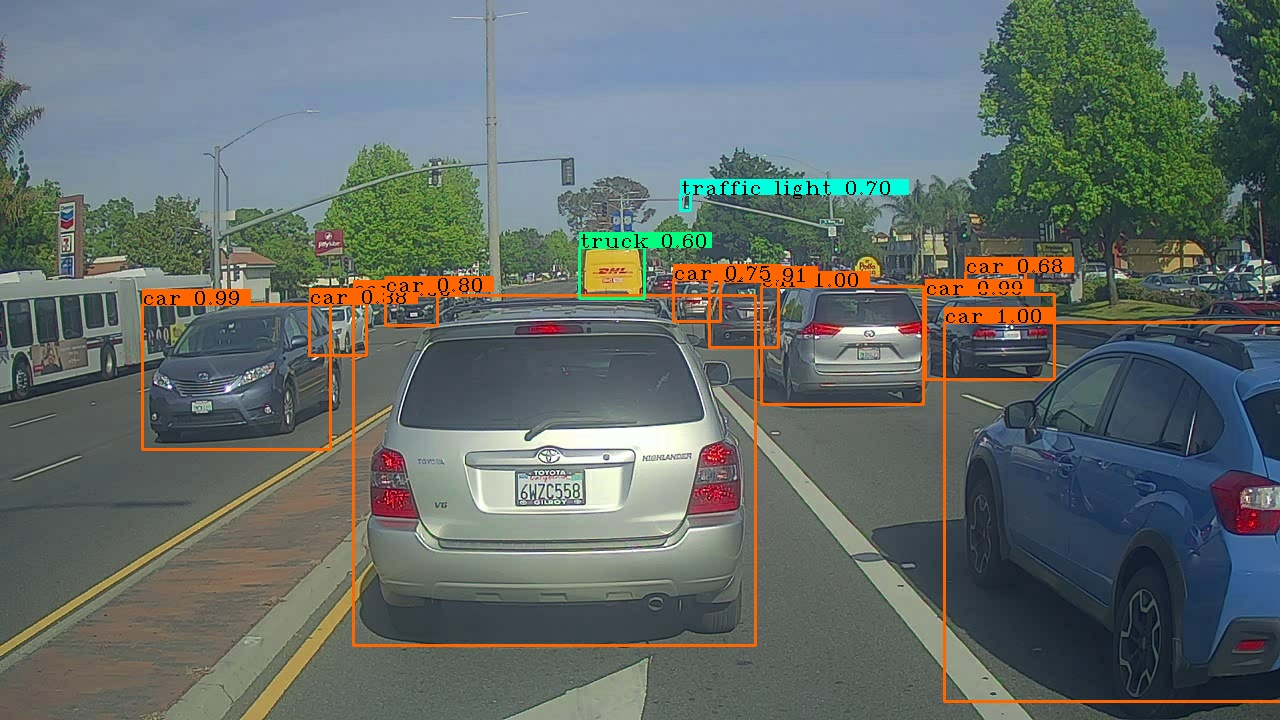

In [15]:
img = img_show('test.jpg', out_scores, out_boxes, out_classes, class_names)

### 4 - 将上面所有的函数结合起来

In [16]:
# 使用前面构建好的graph来探测图片中的车辆
def predict(model, image_file, anchors, class_names):
    img_raw, img = preprocess_image(image_file, model_image_size = (416, 416))
    yolo_outputs = yolo_model(img)
    outputs = yolo_head(yolo_outputs, anchors, len(class_names))
    out_scores, out_boxes, out_classes = yolo_eval(outputs)
    img = img_show(image_file, out_scores, out_boxes, out_classes, class_names)
    return img

Found 9 boxes for 0070.jpg
car 0.98 (367, 294) (447, 356)
car 0.94 (567, 285) (593, 299)
traffic light 0.91 (535, 67) (569, 119)
truck 0.72 (0, 297) (159, 456)
traffic light 0.71 (817, 181) (836, 217)
car 0.71 (491, 290) (513, 306)
car 0.61 (593, 283) (614, 294)
traffic light 0.54 (818, 234) (834, 254)
traffic light 0.53 (378, 97) (404, 146)


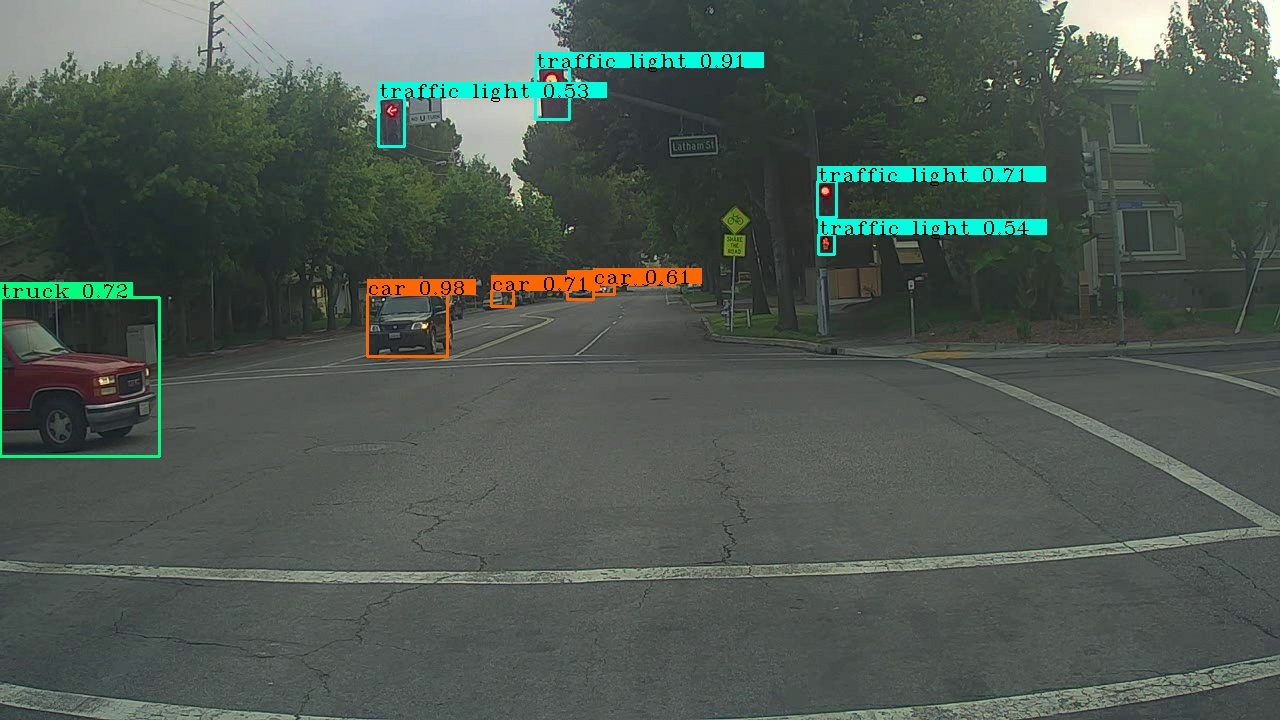

In [17]:
img = predict(yolo_model, '0070.jpg', anchors, class_names)

上面我们只是探测了一张图片，如果探测车辆拍摄的每一张图片，就会出现下面的连续的自动驾驶实时探测的效果:

<center>
<video width="400" height="200" src="nb_images/pred_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>